In [2]:
import pandas as pd
import geopandas as gpd
from scipy import stats
import numpy as np

## Import file

In [3]:
gdf = gpd.read_file('./hypo_testing_data_2007_2018.geojson')

note: 
- current solar potential data sample does not yet utilize 2007-2018 meteorological data
- data sample excluded buildings with -999 values (no value)

## File Overview

In [4]:
print(gdf.columns)

Index(['id', 'address', 'num_panels', 'panel_area', 'kWp', 'total_kwh',
       'avg_month_1', 'avg_month_2', 'avg_month_3', 'avg_month_4',
       'avg_month_5', 'avg_month_6', 'avg_month_7', 'avg_month_8',
       'avg_month_9', 'avg_month_10', 'avg_month_11', 'avg_month_12',
       'PVOUT_yearly', 'PVOUT_month_1', 'PVOUT_month_2', 'PVOUT_month_3',
       'PVOUT_month_4', 'PVOUT_month_5', 'PVOUT_month_6', 'PVOUT_month_7',
       'PVOUT_month_8', 'PVOUT_month_9', 'PVOUT_month_10', 'PVOUT_month_11',
       'PVOUT_month_12', 'geometry'],
      dtype='object')


Sinagpala columns:
- `total_kwh` -> YEARLY (kWh)
- `avg_month_1` - `avg_month_12` -> MONTHLY (kWh)

GlobalSolarAtlas columns:
- `PVOUT_yearly` -> (Long-term Average Yearly 2007-2018) (kWh)
- `PVOUT_month_1` - `PVOUT_month_12` -> (Long-term Average Monthly 2007-2018) (kWh)

GlobalSolarAtlas PVOUT values have already been converted from kWh/kWp to kWh in GlobalSolarAtlas/hypo_testing_data_generator.ipynb https://colab.research.google.com/drive/1q4uGxJIUTpvq_U9BKCGtb3JeX9rv-zcZ#scrollTo=ntzLviJyRsHp

In [5]:
len(gdf)

36084

In [6]:
gdf.head()

,id,address,num_panels,panel_area,kWp,total_kwh,avg_month_1,avg_month_2,avg_month_3,avg_month_4,...,PVOUT_month_4,PVOUT_month_5,PVOUT_month_6,PVOUT_month_7,PVOUT_month_8,PVOUT_month_9,PVOUT_month_10,PVOUT_month_11,PVOUT_month_12,geometry
0,way/4392200,"J3MX+763, Marikina, 1800 Metro Manila, Philipp...",4.0,6.5472,1.00,1.217989e+03,98.591349,103.947040,121.755624,123.893457,...,139.745200,129.662424,112.013180,103.904954,100.557832,103.257441,107.600121,108.328293,99.944000,"POLYGON ((121.09815 14.63357, 121.09786 14.633..."
1,way/4947814,"1800 Riverbanks Ave, Marikina, 1800 Metro Mani...",3308.0,5414.5344,827.00,9.277296e+05,69743.788426,75217.508363,91279.128872,96706.868274,...,115217.646057,107649.768250,93211.169243,86601.787918,83909.898880,85792.978233,88627.108849,88720.558990,81782.029495,"POLYGON ((121.08072 14.62996, 121.08078 14.629..."
2,way/4947816,"300 Riverbanks Ave, Sto. Nino, Marikina, 1800 ...",15753.0,25784.5104,3938.25,4.419620e+06,324317.626238,354160.387099,434811.218795,465435.831807,...,548677.018845,512638.089249,443880.153894,412405.672634,399586.649654,408554.046587,422050.437029,422495.455193,389453.540096,"POLYGON ((121.08178 14.63214, 121.08150 14.631..."
3,way/5105906,"Block 5 Lot 33 C M Recto Santo Nino, Marikina,...",16260.0,26614.3680,4065.00,4.557989e+06,343586.623491,370718.567004,449602.075437,474947.640560,...,561999.262574,517432.740888,449102.866865,414614.597758,400319.467229,416293.444808,439217.701101,444049.161731,411670.801334,"POLYGON ((121.11541 14.66517, 121.11576 14.663..."
4,way/5106137,"109 C.M. Recto St, Marikina, Metro Manila, Phi...",241.0,394.4688,60.25,6.861694e+04,4946.321805,5424.338459,6698.190303,7265.158977,...,8332.575184,7663.378298,6647.984779,6135.558695,5920.767298,6163.575184,6512.844257,6593.760147,6109.410309,"POLYGON ((121.11880 14.66317, 121.11900 14.663..."


# Performing Hypothesis Testing

To compare the solar potential predicted with the one from GSA, we first generate the difference column named *kwh_difference* which is the result of the subtraction of the *total_kwh* column from the *PVOUT_yearly* column.

Text(0.5, 0, 'kWh')

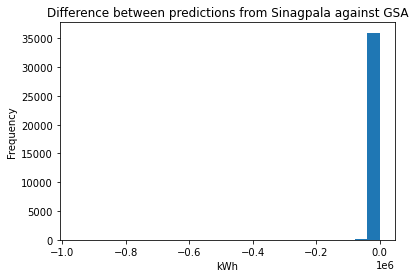

In [7]:
gdf['kwh_difference'] = gdf['total_kwh'] - gdf['PVOUT_yearly']
ax = gdf['kwh_difference'].plot(kind="hist", title="Difference between predictions from Sinagpala against GSA", bins=25)
ax.set_xlabel('kWh')

We can see that our data has a left-skewed distribution with outliers.

Original:  36084
W/o outliers:  32625


Text(0.5, 0, 'kWh')

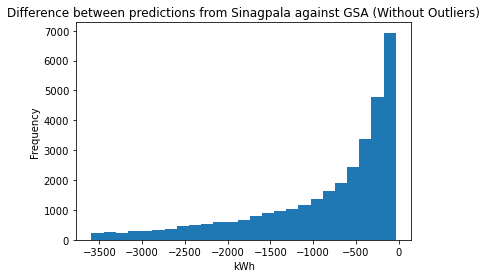

In [8]:
# Remove outliers
# clean_gdf = gdf[(np.abs(stats.zscore(gdf['kwh_difference'])) < 3)]
cols = ['kwh_difference'] # one or more

Q1 = gdf[cols].quantile(0.25)
Q3 = gdf[cols].quantile(0.75)
# Merge GSA and Sinagpala Predictions:
IQR = Q3 - Q1

clean_gdf = gdf[~((gdf[cols] < (Q1 - 1.5 * IQR)) |(gdf[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Remove panels with 0 total kwh
clean_gdf = clean_gdf[(clean_gdf['total_kwh'] > 0) & (clean_gdf['PVOUT_yearly'] > 0)]

print("Original: ", len(gdf))
print("W/o outliers: ", len(clean_gdf))

# Plot the new df
ax = clean_gdf['kwh_difference'].plot(kind="hist", title="Difference between predictions from Sinagpala against GSA (Without Outliers)", xlabel="kWh", bins=25)
ax.set_xlabel('kWh')

In [28]:
min(clean_gdf['kwh_difference'])

-3645.94290331893

In [29]:
max(clean_gdf['kwh_difference'])

-33.541825527189985

Had our data conformed to the normal distribution, we could have used the **paired t-test** which measures the mean difference between pairs of measurements. 

An alternative to this is the **Wilcoxon signed-rank** test which is a nonparametric test that functions similarly as the paired t-test for data with nonuniform distributions.

To test if there is a difference between the two values, we can perform a two-sided test where the:

**Null Hypothesis**:median of the differences is zero 

**Alt Hypothesis**: median of the differences is different from zero

In [30]:
w, p = stats.wilcoxon(clean_gdf['kwh_difference'], alternative='two-sided')

# Get the p-value
print("P-value: ", p)

P-value:  0.0


With a p-value of 0 we have strong evidence to reject the null hypothesis meaning there is a difference between the predicted pv of the two.

In [31]:
# Perform an upper-tailed test
w, p = stats.wilcoxon(clean_gdf['kwh_difference'], alternative='greater')

# Get the p-value
print("P-value: ", p)

P-value:  1.0


In [32]:
def get_change(current, previous):
    if current == previous:
        return 100.0
    try:
        return (abs(current - previous) / previous) * 100.0
    except ZeroDivisionError:
        return 0

Visualize the percent difference between total_kwh and PVOUT_yearly

In [33]:
clean_gdf['percent_difference'] = clean_gdf.apply(lambda x: get_change(x.total_kwh, x.PVOUT_yearly), axis=1)

In [34]:
clean_gdf.head()[['total_kwh', 'PVOUT_yearly', 'percent_difference']]

,total_kwh,PVOUT_yearly,percent_difference
0,1217.988704,1361.234589,10.523233
59,25882.259955,28966.152039,10.646537
73,7545.717269,8843.614197,14.676092
76,15676.747602,19047.784424,17.697790
78,9724.049856,11564.726257,15.916299


Text(0.5, 0, 'Percentage')

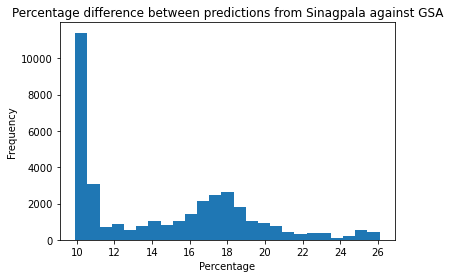

In [35]:
ax = clean_gdf['percent_difference'].plot(kind="hist", title="Percentage difference between predictions from Sinagpala against GSA", xlabel="kWh", bins=25)
ax.set_xlabel('Percentage')

In [36]:
min(clean_gdf['percent_difference'])

9.92247207625192

In [37]:
max(clean_gdf['percent_difference'])

26.100900978448127

From the graph, we can see that we have a right skewed distribution. As such, we can use the median to measure central tendency. 

In [38]:
# Get the average percentage difference between the two 
clean_gdf['percent_difference'].median()

14.233560766715826

In [39]:
# Get the average percentage difference between the two 
clean_gdf['percent_difference'].median()

14.233560766715826

In [40]:
hypotest_dict = {}

for i in range (1, 13): 
  clean_gdf['kwh_difference'] = clean_gdf['avg_month_{}'.format(i)] - clean_gdf['PVOUT_month_{}'.format(i)] 
  w, p = stats.wilcoxon(clean_gdf['kwh_difference'], alternative='two-sided')
  hypotest_dict[i] = p

In [41]:
hypotest_dict

{1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0}